## Experiments with vanilla GAN, Wasserstein GAN and Wasserstein GAN with gradient penalty on CIFAR10.

In [1]:
!pip install --upgrade --no-cache-dir gdown

REPO_NAME = "2024-DGM-AIMasters-course"
!if [ -d {REPO_NAME} ]; then rm -Rf {REPO_NAME}; fi
!git clone https://github.com/r-isachenko/{REPO_NAME}.git
!cd {REPO_NAME}
!pip install ./{REPO_NAME}/homeworks/
!mv ./{REPO_NAME}/homeworks/stylegan.py ./stylegan.py
!mv ./{REPO_NAME}/homeworks/inception.py ./inception.py
!rm -Rf {REPO_NAME}

Cloning into '2024-DGM-AIMasters-course'...
remote: Enumerating objects: 1079, done.
remote: Counting objects: 100% (252/252), done.
remote: Compressing objects: 100% (140/140), done.
remote: Total 1079 (delta 118), reused 243 (delta 111), pack-reused 827
Receiving objects: 100% (1079/1079), 451.81 MiB | 47.46 MiB/s, done.
Resolving deltas: 100% (437/437), done.
Updating files: 100% (359/359), done.
Processing ./2024-DGM-AIMasters-course/homeworks
  Preparing metadata (setup.py) ... done
  Created wheel for dgm_utils: filename=dgm_utils-0.1.0-py3-none-any.whl size=4124 sha256=36641e4686ee11e322bb94e16585dc8601d0f54357248447646ba6cf8073fdd6
  Stored in directory: /tmp/pip-ephem-wheel-cache-ymf6tpv0/wheels/4f/a3/e1/7ce89a0fe02e2d2ab9af498ba5f276230a0950106cd1d89c59
Successfully built dgm_utils


We write some technical functions to download data and visulize it 

In [2]:
import numpy as np
from typing import Tuple

import torchvision


def load_MNIST(with_targets: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    train_dataset = torchvision.datasets.MNIST(root="./", train=True, download=True)
    test_dataset = torchvision.datasets.MNIST(root="./", train=False, download=True)
    train_data, test_data = train_dataset.data.numpy(), test_dataset.data.numpy()
    axis_index = len(train_data.shape)
    train_data = np.expand_dims(train_data, axis=axis_index)
    test_data = np.expand_dims(test_data, axis=axis_index)

    if with_targets:
        train_labels, test_labels = train_dataset.targets.numpy(), test_dataset.targets.numpy()
        return train_data, test_data, train_labels, test_labels

    return train_data, test_data


def load_CIFAR10(with_targets: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    train_dataset = torchvision.datasets.CIFAR10(root="./", train=True, download=True)
    test_dataset = torchvision.datasets.CIFAR10(root="./", train=False, download=True)
    train_data, test_data = train_dataset.data, test_dataset.data

    if with_targets:
        train_labels, test_labels = train_dataset.targets.numpy(), test_dataset.targets.numpy()
        return train_data, test_data, train_labels, test_labels

    return train_data, test_data


def _load_dataset(name: str, with_targets: bool = False) -> Tuple[np.ndarray, np.ndarray]:
    if name == "mnist":
        return load_MNIST(with_targets=with_targets)
    elif name == "cifar10":
        return load_CIFAR10(with_targets=with_targets)
    else:
        raise ValueError("The argument name must have the values 'mnist' or 'cifar10'")


def load_dataset(
    name: str, flatten: bool = False, binarize: bool = True, with_targets: bool = False
) -> Tuple[np.ndarray, np.ndarray]:

    dataset = _load_dataset(name, with_targets=with_targets)

    train_data = dataset[0]
    test_data = dataset[1]

    train_data = train_data.astype("float32")
    test_data = test_data.astype("float32")

    if binarize:
        train_data = (train_data > 128).astype("float32")
        test_data = (test_data > 128).astype("float32")
    else:
        train_data = train_data / 255.0
        test_data = test_data / 255.0

    train_data = np.transpose(train_data, (0, 3, 1, 2))
    test_data = np.transpose(test_data, (0, 3, 1, 2))

    if flatten:
        train_data = train_data.reshape(len(train_data.shape[0]), -1)
        test_data = test_data.reshape(len(train_data.shape[0]), -1)

    if with_targets:
        train_labels = dataset[2]
        test_labels = dataset[3]
        return train_data, train_labels, test_data, test_labels

    return train_data, test_data

In [3]:
from collections import defaultdict
from tqdm.notebook import tqdm
from typing import Tuple

import torch
from torch import optim


def train_epoch(
    model: object,
    train_loader: object,
    optimizer: object,
    use_cuda: bool,
    loss_key: str = "total",
) -> defaultdict:
    model.train()

    stats = defaultdict(list)
    for x in train_loader:
        if use_cuda:
            x = x.cuda()
        losses = model.loss(x)
        optimizer.zero_grad()
        losses[loss_key].backward()
        optimizer.step()

        for k, v in losses.items():
            stats[k].append(v.item())

    return stats


def eval_model(model: object, data_loader: object, use_cuda: bool) -> defaultdict:
    model.eval()
    stats = defaultdict(float)
    with torch.no_grad():
        for x in data_loader:
            if use_cuda:
                x = x.cuda()
            losses = model.loss(x)
            for k, v in losses.items():
                stats[k] += v.item() * x.shape[0]

        for k in stats.keys():
            stats[k] /= len(data_loader.dataset)
    return stats


def train_model(
    model: object,
    train_loader: object,
    test_loader: object,
    epochs: int,
    lr: float,
    use_tqdm: bool = False,
    use_cuda: bool = False,
    loss_key: str = "total_loss",
) -> Tuple[dict, dict]:
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = defaultdict(list)
    test_losses = defaultdict(list)
    forrange = tqdm(range(epochs)) if use_tqdm else range(epochs)
    if use_cuda:
        model = model.cuda()

    for epoch in forrange:
        model.train()
        train_loss = train_epoch(model, train_loader, optimizer, use_cuda, loss_key)
        test_loss = eval_model(model, test_loader, use_cuda)

        for k in train_loss.keys():
            train_losses[k].extend(train_loss[k])
            test_losses[k].append(test_loss[k])
    return dict(train_losses), dict(test_losses)

In [4]:
import numpy as np
from matplotlib import pyplot as plt
from torchvision.utils import make_grid
from typing import Dict, List, Optional, Tuple

import torch


TICKS_FONT_SIZE = 12
LEGEND_FONT_SIZE = 12
LABEL_FONT_SIZE = 14
TITLE_FONT_SIZE = 16


def plot_training_curves(
    train_losses: Dict[str, np.ndarray],
    test_losses: Dict[str, np.ndarray],
    logscale_y: bool = False,
    logscale_x: bool = False,
) -> None:
    n_train = len(train_losses[list(train_losses.keys())[0]])
    n_test = len(test_losses[list(train_losses.keys())[0]])
    x_train = np.linspace(0, n_test - 1, n_train)
    x_test = np.arange(n_test)

    plt.figure()
    for key, value in train_losses.items():
        plt.plot(x_train, value, label=key + "_train")

    for key, value in test_losses.items():
        plt.plot(x_test, value, label=key + "_test")

    if logscale_y:
        plt.semilogy()

    if logscale_x:
        plt.semilogx()

    plt.legend(fontsize=LEGEND_FONT_SIZE)
    plt.xlabel("Epoch", fontsize=LABEL_FONT_SIZE)
    plt.ylabel("Loss", fontsize=LABEL_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    plt.grid()
    plt.show()


def show_samples(
    samples: np.ndarray,
    title: str,
    figsize: Optional[Tuple[int, int]] = None,
    nrow: Optional[int] = None,
) -> None:
    if isinstance(samples, np.ndarray):
        samples = torch.FloatTensor(samples)
    if nrow is None:
        nrow = int(np.sqrt(len(samples)))
    grid_samples = make_grid(samples, nrow=nrow)

    grid_img = grid_samples.permute(1, 2, 0)
    if figsize is None:
        figsize = (6, 6)

    grid_img = grid_img.clip(0, 1)
    plt.figure(figsize=figsize)
    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.imshow(grid_img)
    plt.axis("off")
    plt.show()


def visualize_images(data: np.ndarray, title: str) -> None:
    idxs = np.random.choice(len(data), replace=False, size=(100,))
    images = data[idxs]
    show_samples(images, title)


def visualize_2d_data(
    train_data: np.ndarray,
    test_data: np.ndarray,
    train_labels: Optional[str] = None,
    test_labels: Optional[str] = None,
) -> None:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    ax1.set_title("train", fontsize=TITLE_FONT_SIZE)
    ax1.scatter(train_data[:, 0], train_data[:, 1], s=1, c=train_labels)
    ax1.tick_params(labelsize=LABEL_FONT_SIZE)
    ax2.set_title("test", fontsize=TITLE_FONT_SIZE)
    ax2.scatter(test_data[:, 0], test_data[:, 1], s=1, c=test_labels)
    ax2.tick_params(labelsize=LABEL_FONT_SIZE)
    plt.show()


def visualize_2d_samples(
    data: np.ndarray,
    title: str,
    labels: Optional[str] = None,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
) -> None:
    plt.figure(figsize=(5, 5))
    plt.scatter(data[:, 0], data[:, 1], s=1, c=labels)
    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=LABEL_FONT_SIZE)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=LABEL_FONT_SIZE)
    plt.show()


def visualize_2d_densities(
    x_grid: np.ndarray,
    y_grid: np.ndarray,
    densities: np.ndarray,
    title: str,
    xlabel: Optional[str] = None,
    ylabel: Optional[str] = None,
) -> None:
    densities = densities.reshape([y_grid.shape[0], y_grid.shape[1]])
    plt.figure(figsize=(5, 5))
    plt.pcolor(x_grid, y_grid, densities)
    plt.pcolor(x_grid, y_grid, densities)

    plt.title(title, fontsize=TITLE_FONT_SIZE)
    plt.xticks(fontsize=TICKS_FONT_SIZE)
    plt.yticks(fontsize=TICKS_FONT_SIZE)
    if xlabel is not None:
        plt.xlabel(xlabel, fontsize=LABEL_FONT_SIZE)
    if ylabel is not None:
        plt.ylabel(ylabel, fontsize=LABEL_FONT_SIZE)
    plt.show()

In [6]:
import os
import numpy as np
import matplotlib.pyplot as plt
from functools import partial
from typing import Optional
from IPython.display import clear_output

import scipy
from scipy.stats import entropy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torch.nn import functional as F
from inception import InceptionV3

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.enabled = False


def reset_seed():
    OUTPUT_SEED = 0xBADBEEF
    torch.manual_seed(OUTPUT_SEED)
    np.random.seed(OUTPUT_SEED)


USE_CUDA = torch.cuda.is_available()

print("cuda is available:", USE_CUDA)

cuda is available: True


In [7]:

def plot_losses(losses: np.ndarray, title: str):
    n_itr = len(losses)
    xs = np.arange(n_itr)

    plt.figure(figsize=(7, 5))
    plt.plot(xs, losses)
    plt.title(title, fontsize=14)
    plt.xlabel("Iterations", fontsize=14)
    plt.ylabel("Loss", fontsize=14)

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.show()

## Vanilla GANs on CIFAR 10

Let's firstly visualize dataset

100%|██████████| 170498071/170498071 [00:02<00:00, 77782105.17it/s]


Extracting ./cifar-10-python.tar.gz to ./
Files already downloaded and verified


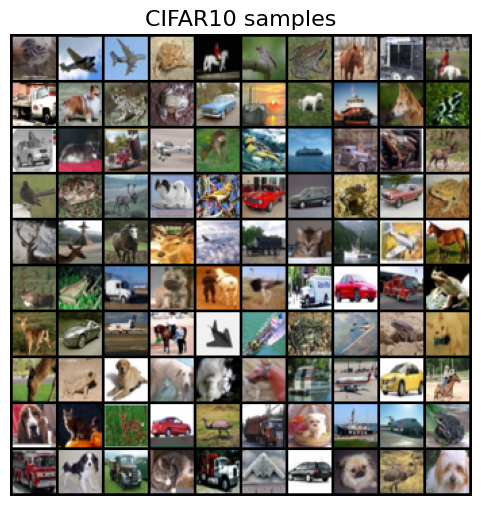

In [9]:
train_data, test_data = load_dataset("cifar10", flatten=False, binarize=False)
visualize_images(train_data, "CIFAR10 samples")

In [34]:
from torch.utils.data import DataLoader
import torch.nn as nn

batch_size = 100
data_loader = DataLoader(cifar, batch_size, shuffle=True)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

image_size = 3072
hidden_size = 256


D = nn.Sequential(
    nn.Linear(image_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, hidden_size),
    nn.LeakyReLU(0.2),
    nn.Linear(hidden_size, 1),
    nn.Sigmoid())

D.to(device)

latent_size = 64
G = nn.Sequential(
    nn.Linear(latent_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, hidden_size),
    nn.ReLU(),
    nn.Linear(hidden_size, image_size),
    nn.Tanh())
G.to(device)

Sequential(
  (0): Linear(in_features=64, out_features=256, bias=True)
  (1): ReLU()
  (2): Linear(in_features=256, out_features=256, bias=True)
  (3): ReLU()
  (4): Linear(in_features=256, out_features=3072, bias=True)
  (5): Tanh()
)

In [35]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(D.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(G.parameters(), lr=0.0002)

def reset_grad():
    d_optimizer.zero_grad()
    g_optimizer.zero_grad()

def train_discriminator(images):
    # Create the labels which are later used as input for the BCE loss
    real_labels = torch.ones(batch_size, 1).to(device)
    fake_labels = torch.zeros(batch_size, 1).to(device)
        
    # Loss for real images
    outputs = D(images)
    d_loss_real = criterion(outputs, real_labels)
    real_score = outputs

    # Loss for fake images
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    outputs = D(fake_images)
    d_loss_fake = criterion(outputs, fake_labels)
    fake_score = outputs

    # Combine losses
    d_loss = d_loss_real + d_loss_fake
     # Reset gradients
    reset_grad()
    # Compute gradients
    d_loss.backward()
    # Adjust the parameters using backprop
    d_optimizer.step()
    
    return d_loss, real_score, fake_score

In [36]:
def train_generator():
    # Generate fake images and calculate loss
    z = torch.randn(batch_size, latent_size).to(device)
    fake_images = G(z)
    labels = torch.ones(batch_size, 1).to(device)
    g_loss = criterion(D(fake_images), labels)

    # Backprop and optimize
    reset_grad()
    g_loss.backward()
    g_optimizer.step()
    return g_loss, fake_images

In [37]:
import os

sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

Saving fake_images-0000.png


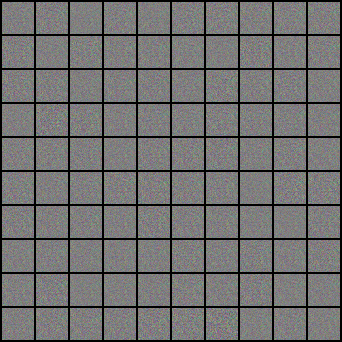

In [39]:
sample_vectors = torch.randn(batch_size, latent_size).to(device)

def save_fake_images(index):
    fake_images = G(sample_vectors)
    fake_images = fake_images.reshape(fake_images.size(0), 3, 32, 32)
    fake_fname = 'fake_images-{0:0=4d}.png'.format(index)
    print('Saving', fake_fname)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=10)
    
# Before training
save_fake_images(0)
Image(os.path.join(sample_dir, 'fake_images-0000.png'))

In [40]:
%%time

num_epochs = 1000
total_step = len(data_loader)
d_losses, g_losses, real_scores, fake_scores = [], [], [], []

for epoch in range(num_epochs):
    for i, (images, _) in enumerate(data_loader):
        # Load a batch & transform to vectors
        images = images.reshape(batch_size,-1).to(device)
        
        
        # Train the discriminator and generator
        d_loss, real_score, fake_score = train_discriminator(images)
        g_loss, fake_images = train_generator()
        
        # Inspect the losses
        if (i+1) % 200 == 0:
            d_losses.append(d_loss.item())
            g_losses.append(g_loss.item())
            real_scores.append(real_score.mean().item())
            fake_scores.append(fake_score.mean().item())
            print('Epoch [{}/{}], Step [{}/{}], d_loss: {:.4f}, g_loss: {:.4f}, D(x): {:.2f}, D(G(z)): {:.2f}' 
                  .format(epoch, num_epochs, i+1, total_step, d_loss.item(), g_loss.item(), 
                          real_score.mean().item(), fake_score.mean().item()))
        
    # Sample and save images
    save_fake_images(epoch+1)

Epoch [0/1000], Step [200/500], d_loss: 0.0505, g_loss: 5.5032, D(x): 0.98, D(G(z)): 0.02
Epoch [0/1000], Step [400/500], d_loss: 0.0332, g_loss: 5.3033, D(x): 0.99, D(G(z)): 0.02
Saving fake_images-0001.png
Epoch [1/1000], Step [200/500], d_loss: 0.0195, g_loss: 6.7726, D(x): 0.99, D(G(z)): 0.01
Epoch [1/1000], Step [400/500], d_loss: 0.0431, g_loss: 4.7774, D(x): 0.99, D(G(z)): 0.03
Saving fake_images-0002.png
Epoch [2/1000], Step [200/500], d_loss: 0.0202, g_loss: 4.8904, D(x): 1.00, D(G(z)): 0.01
Epoch [2/1000], Step [400/500], d_loss: 0.0102, g_loss: 5.7617, D(x): 1.00, D(G(z)): 0.01
Saving fake_images-0003.png
Epoch [3/1000], Step [200/500], d_loss: 0.0100, g_loss: 8.1604, D(x): 1.00, D(G(z)): 0.01
Epoch [3/1000], Step [400/500], d_loss: 0.0067, g_loss: 7.8421, D(x): 1.00, D(G(z)): 0.00
Saving fake_images-0004.png
Epoch [4/1000], Step [200/500], d_loss: 0.0073, g_loss: 6.4485, D(x): 1.00, D(G(z)): 0.01
Epoch [4/1000], Step [400/500], d_loss: 0.0579, g_loss: 8.4801, D(x): 0.99, D(


KeyboardInterrupt



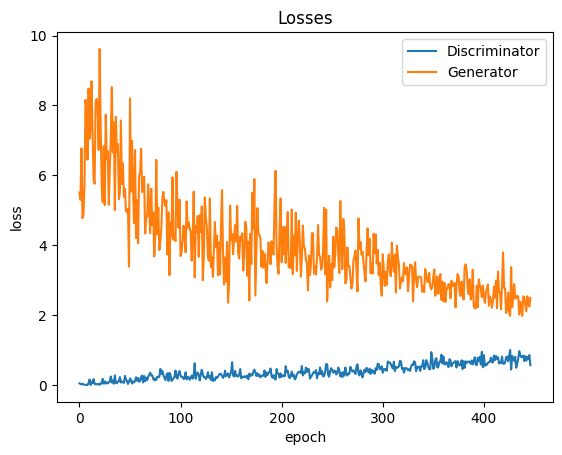

In [41]:
plt.plot(d_losses, '-')
plt.plot(g_losses, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

## Wasserstein GANs on CIFAR 10

### WGAN 

[WGAN](https://arxiv.org/abs/1701.07875) model uses weight clipping to enforce Lipschitzness of the critic.

The model objective is
$$
\min_{G} W(\pi || p) \approx \min_{G} \max_{\boldsymbol{\phi} \in \boldsymbol{\Phi}} \left[ \mathbb{E}_{\pi(\mathbf{x})} f_{\boldsymbol{\phi}}(\mathbf{x})  - \mathbb{E}_{p(\mathbf{z})} f_{\boldsymbol{\phi}}(G_{\boldsymbol{\theta}}(\mathbf{z}))\right].
$$
Here $f_{\boldsymbol{\phi}}(\mathbf{x})$ is the critic model. The critic weights $\boldsymbol{\phi}$ should lie in the compact set $\boldsymbol{\Phi} = [-c, c]^d$.

We will use convolutional networks for the generator $G_{\boldsymbol{\theta}}(\mathbf{z})$ and the critic $f_{\boldsymbol{\phi}}(\mathbf{x})$.

First of all, let define generator network. It will be the same for all WGAN models.

In [ ]:
class ConvGenerator(nn.Module):
    def __init__(self, input_size: int = 128, n_channels: int = 64) -> None:
        super().__init__()
        self.n_channels = n_channels
        self.input_size = input_size
        self.linear = nn.Linear(input_size, 4 * 4 * 4 * n_channels)
        self.conv_transpose1 = nn.ConvTranspose2d(n_channels * 4, n_channels * 2, kernel_size=4, stride=2, padding=1)
        self.conv_transpose2 = nn.ConvTranspose2d(n_channels * 2, n_channels, kernel_size=4, stride=2, padding=1)
        self.conv_transpose3 = nn.ConvTranspose2d(n_channels, 3, kernel_size=4, stride=2, padding=1)
        self.relu = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(n_channels * 2)
        self.bn2 = nn.BatchNorm2d(n_channels)
        self.tanh = nn.Tanh()

    @property
    def device(self):
        return next(self.parameters()).device

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        output = self.linear(input)
        output = self.relu(output)
        output = output.view(-1, 4*self.n_channels, 4,4)
        output = self.conv_transpose1(output)
        output = self.bn1(output)
        output = self.conv_transpose2(output)
        output = self.bn2(output)
        output = self.relu(output)
        output = self.conv_transpose3(output)
        output = self.tanh(output)
        return output.view(-1, 3, 32, 32)

    def sample(self, n_samples: int) -> torch.Tensor:
        # sample from standard normal distribution and apply the model
        z = torch.randn(n_samples, self.input_size).to(self.device)
        output = self.forward(z)
        return output


def test_conv_generator():
    model = ConvGenerator(input_size=4, n_channels=32)
    x = torch.randn((2, 4))
    out = model(x)
    assert list(out.size()) == [2, 3, 32, 32], out.size()

    out = model.sample(10)
    assert list(out.size()) == [10, 3, 32, 32], out.size()


test_conv_generator()

Now it is time to define our critic. Here we will use the same class for all WGAN models, but the arguments will depend on the WGAN mode.

In [ ]:
class ConvCritic(nn.Module):
    def __init__(
        self, n_channels: int, clip_c: Optional[float] = None,
    ) -> None:
        super().__init__()
        self.n_channels = n_channels
        self.clip_c = clip_c
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.n_channels*32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(self.n_channels*32, self.n_channels*64, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(self.n_channels*64, self.n_channels*128, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4*4*self.n_channels*128, 1)
        )


    def clip_weights(self) -> None:
        for layer in self.net:
            if isinstance(layer, nn.Linear) or isinstance(layer, nn.Conv2d):
                # clip the weight to the range [-clip_c, clip_c]
                weight = torch.clamp(layer.weight.data, -self.clip_c, self.clip_c)
                layer.weight.data = weight

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # 1) clip the critic weights (if clip_c is given)
        # 2) apply all layers
        if self.clip_c is not None:
              self.clip_weights()
        output = self.net(x)
        return output


def test_conv_critic():
    model = ConvCritic(n_channels=4, clip_c=0.01)
    x = torch.randn((2, 3, 32, 32))
    out = model(x)
    assert list(out.size()) == [2, 1], out.size()


test_conv_critic()

In [ ]:
from tqdm import tqdm
def train_wgan(
    generator: nn.Module,
    critic: nn.Module,
    train_loader: object,
    critic_steps: int,
    batch_size: int,
    n_epochs: int,
    lr: float,
    use_cuda: bool = False,
    gp_weight: Optional[float] = None,
) -> dict:

    if use_cuda:
        critic = critic.cuda()
        generator = generator.cuda()
    critic.train()
    generator.train()

    gen_optimizer = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0, 0.9))
    critic_optimizer = torch.optim.Adam(critic.parameters(), lr=lr, betas=(0, 0.9))

    curr_iter = 0
    d_loss, g_loss = torch.zeros(1), torch.zeros(1)
    batch_loss_history = {"discriminator_losses": [], "generator_losses": []}
    for epoch_i in tqdm(range(n_epochs)):
        critic.train()
        generator.train()
        for batch_i, x in enumerate(train_loader):
            curr_iter += 1
            if use_cuda:
                x = x.cuda()

            # do a critic update
            critic_optimizer.zero_grad()
            fake_data = generator.sample(x.shape[0])

            # D(x_fake) - D(x_real)
            d_loss = (critic(fake_data) - critic(x)).mean()


            if gp_weight is not None:
                gp = gradient_penalty(critic, x, fake_data)
                d_loss += gp_weight * gp

            d_loss.backward()
            critic_optimizer.step()

            # generator update
            if curr_iter % critic_steps == 0:
                gen_optimizer.zero_grad()
                fake_data = generator.sample(batch_size)
                # -D(x_fake)
                g_loss =  - critic(fake_data).mean()
                g_loss.backward()
                gen_optimizer.step()

                batch_loss_history["generator_losses"].append(g_loss.data.cpu().numpy())
                batch_loss_history["discriminator_losses"].append(
                    d_loss.data.cpu().numpy()
                )

        clear_output(wait=True)
        generator.eval()
        critic.eval()
        with torch.no_grad():
            samples = generator.sample(100)
            samples = samples.cpu().detach().numpy()

        show_samples(samples, title=f"Generated samples: epoch: {epoch_i}")

    return batch_loss_history

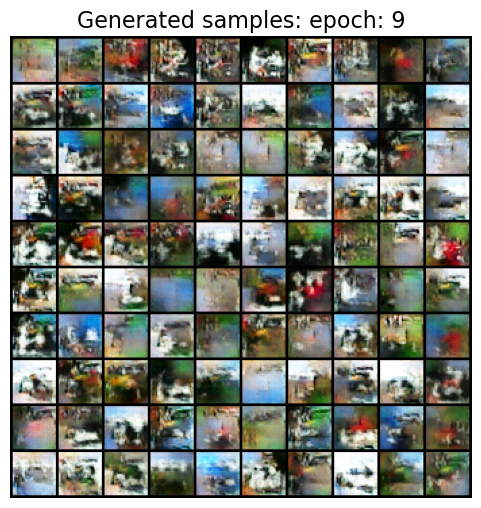

100%|██████████| 10/10 [1:54:20<00:00, 686.05s/it]


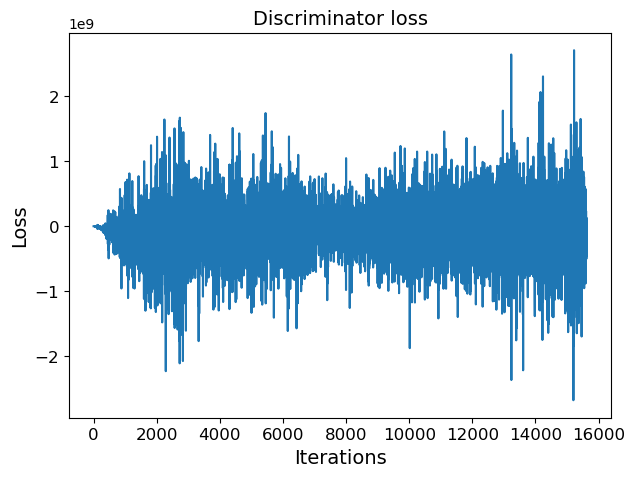

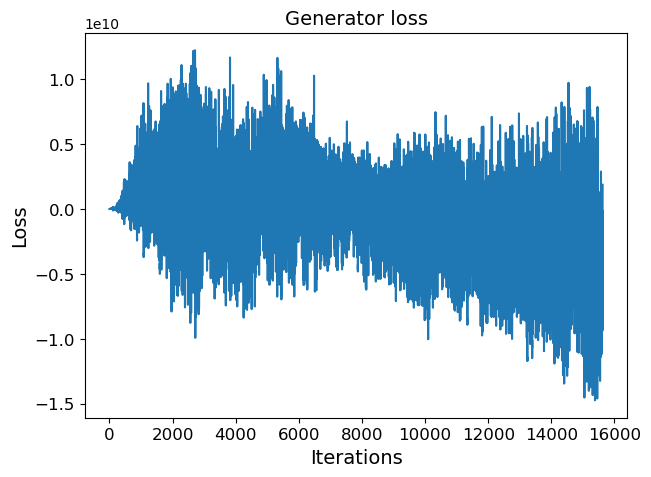

In [ ]:
BATCH_SIZE =   16
N_CHANNELS =   32
N_EPOCHS =   10
CRITIC_STEPS = 2
CLIP_C =   0.9
LR =   1e-3

train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = ConvGenerator(n_channels=N_CHANNELS)
critic = ConvCritic(n_channels=N_CHANNELS, clip_c=CLIP_C)

train_losses = train_wgan(
    generator,
    critic,
    train_loader,
    critic_steps=CRITIC_STEPS,
    batch_size=BATCH_SIZE,
    n_epochs=N_EPOCHS,
    lr=LR,
    use_cuda=USE_CUDA,
)

plot_losses(train_losses["discriminator_losses"], "Discriminator loss")
plot_losses(train_losses["generator_losses"], "Generator loss")

Let sample from our model and draw the samples.

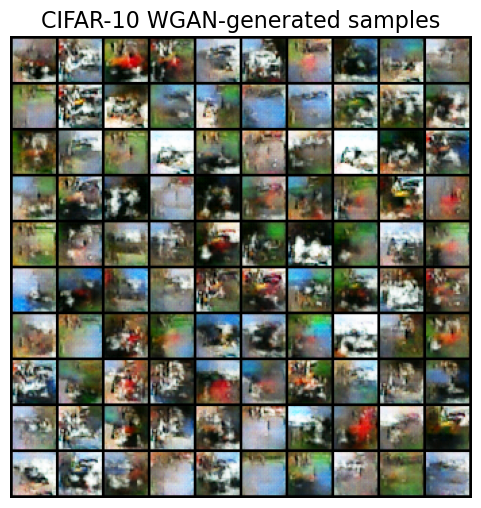

In [ ]:
generator.eval()
critic.eval()
with torch.no_grad():
    samples = generator.sample(100)
    samples = samples.cpu().detach().numpy()


show_samples(samples, title="CIFAR-10 WGAN-generated samples")

### WGAN-GP for CIFAR 10 

[WGAN-GP](https://arxiv.org/pdf/1704.00028.pdf)  model uses gradient penalty to enforce Lipschitzness.

The model objective is
$$
    W(\pi || p) = \underbrace{\mathbb{E}_{\pi(\mathbf{x})} f(\mathbf{x})  - \mathbb{E}_{p(\mathbf{x} | \boldsymbol{\theta})} f(\mathbf{x})}_{\text{original critic loss}} + \lambda \underbrace{\mathbb{E}_{U[0, 1]} \left[ \left( \| \nabla_{\hat{\mathbf{x}}} f(\hat{\mathbf{x}}) \|_2 - 1 \right) ^ 2\right]}_{\text{gradient penalty}},
$$
where the samples $\hat{\mathbf{x}}_t = t \mathbf{x} + (1 - t) \mathbf{y}$ with $t \in [0, 1]$ are uniformly sampled along straight lines between pairs of points: $\mathbf{x}$ from the data distribution $\pi(\mathbf{x})$ and $\mathbf{y}$ from the generator distribution $p(\mathbf{x} | \boldsymbol{\theta}))$.

Let define our gradient penalty loss.

In [ ]:
from torch import linalg as LA
def gradient_penalty(
    critic: object, real_data: torch.Tensor, fake_data: torch.Tensor
) -> torch.Tensor:
    batch_size = real_data.shape[0]
    # Calculate interpolation x_t = t * x_real + (1 - t) x_fake
    # 1) sample t
    # 2) create x_t (be careful about shapes)
    # 3) apply critic to x_t
    if len(real_data.size()) == 2:
        t = torch.rand(batch_size, 1).to(real_data.device)
    elif len(real_data.size()) == 4:
        t = torch.rand(batch_size, 1, 1, 1).to(real_data.device)
    x_t = (t * real_data + (1 - t) * fake_data)
    d_output = critic(x_t)
    
    gradients = torch.autograd.grad(
        outputs=d_output,
        inputs=x_t,
        grad_outputs=torch.ones(d_output.size()).to(fake_data.device),
        create_graph=True,
        retain_graph=True,
    )[0]
    gradients = gradients.reshape(batch_size, -1)
    # compute gradient norm
    gradients_norm = LA.norm(gradients,2, dim=1)
    #print(gradients_norm.size())
    return ((gradients_norm - 1) ** 2).mean()


def test_gradient_penalty():
    x = np.random.normal(size=(10, 4))
    x_norm = np.mean(np.sqrt(x**2))
    x = torch.randn(size=(10, 4))
    x.requires_grad = True
    assert gradient_penalty(lambda x: x, x, x).numpy() == 1
    assert gradient_penalty(lambda x: x * 0, x, x).numpy() == 1


test_gradient_penalty()

We will use the same `ConvGenerator`, `ConvCritic` and `train_wgan()` as for WGAN model here.

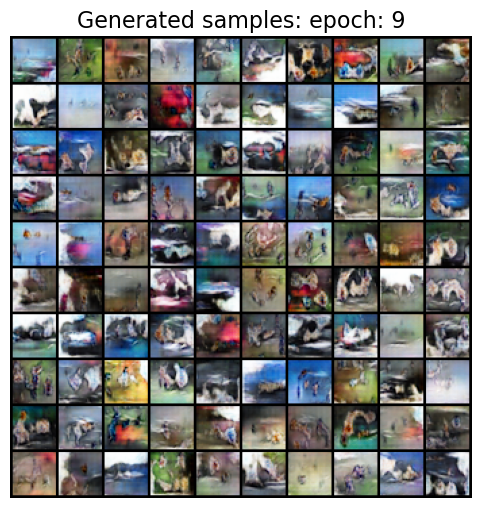

100%|██████████| 10/10 [3:36:56<00:00, 1301.62s/it]


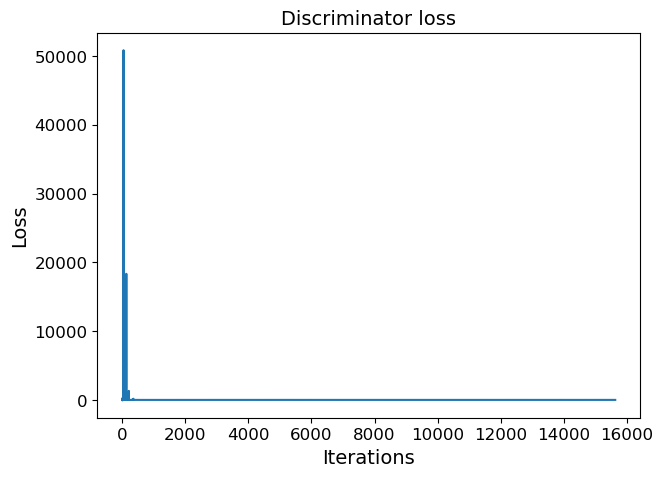

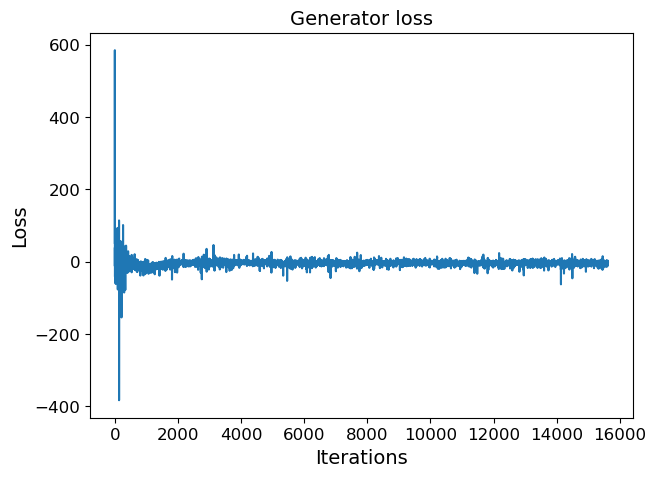

In [ ]:
BATCH_SIZE =   16
N_CHANNELS =   32
N_EPOCHS =   10
CRITIC_STEPS = 2
GP_WEIGHT =  5 
LR = 1e-3


train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)

generator = ConvGenerator(n_channels=N_CHANNELS)
critic = ConvCritic(n_channels=N_CHANNELS)

train_losses = train_wgan(
    generator,
    critic,
    train_loader,
    critic_steps=CRITIC_STEPS,
    batch_size=BATCH_SIZE,
    n_epochs=N_EPOCHS,
    lr=LR,
    gp_weight=GP_WEIGHT,
    use_cuda=USE_CUDA,
)

plot_losses(train_losses["discriminator_losses"], "Discriminator loss")
plot_losses(train_losses["generator_losses"], "Generator loss")

Let sample from our model and draw the samples.

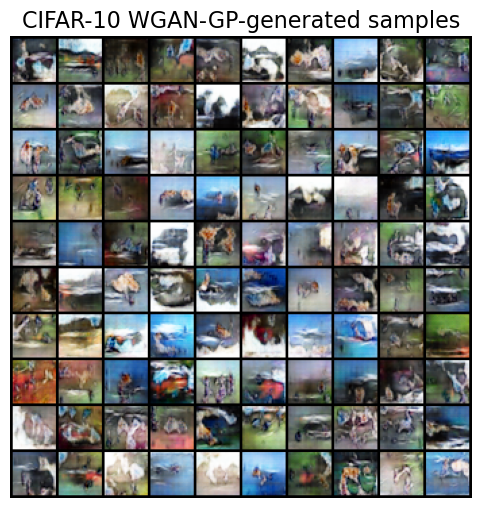

In [ ]:
generator.eval()
critic.eval()
with torch.no_grad():
    samples = generator.sample(100)
    samples = samples.cpu().detach().numpy()


show_samples(samples, title="CIFAR-10 WGAN-GP-generated samples")